In [1]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

## 1. 데이터 준비

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

from PIL import Image

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

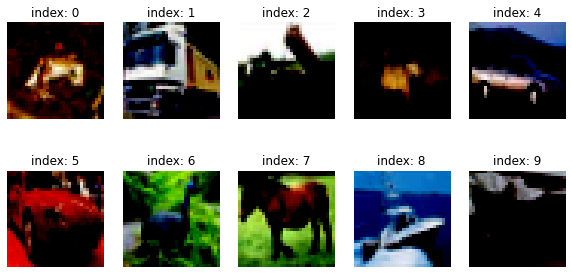

In [3]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

개구리 라벨 데이터 제외

In [4]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:
            new_t_labels.append([0])
        else:
            new_t_labels.append([1])
    return np.array(new_t_labels)

In [5]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [6]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []

for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)

normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)


(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [7]:
train_data  = normal_data
bol_train_labels = normal_labels

test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [9]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [13]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print('DONE')

DONE


In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
for data, label in train_dataset.take(1):
    print(label)
print('DONE')

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)
DONE


In [58]:
for data, label in test_dataset.take(5):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)
tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)
tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)
tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)
tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


## 2. 모델 설계

### Generator

In [17]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', 
                          use_bias=False, kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
    
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        return outputs

In [31]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same',
                                  use_bias=False, kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [32]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64)
        self.encoder_2 = Conv_block(128)
        self.encoder_3 = Conv_block(256)
        self.encoder_4 = Conv_block(512)
        
        self.center = Conv_block(512)
        
        self.decoder_4 = Conv_T_block(512)
        self.decoder_3 = Conv_T_block(256)
        self.decoder_2 = Conv_T_block(128)
        self.decoder_1 = Conv_T_block(64)
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same',
                                                  use_bias=False, kernel_initializer=tf.random_normal_initializer(0., 0.02))
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs)
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

### Discriminator

In [33]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64)
        self.encoder_2 = Conv_block(128)
        self.encoder_3 = Conv_block(256)
        self.encoder_4 = Conv_block(512)
        
        self.center = Conv_block(100)
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                    use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs)
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

### 전체 모델

In [42]:
generator = Generator(num_output_channel=3)
discriminator = Discriminator()

Loss

In [35]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [36]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [37]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + w_context * context_loss + w_encoder * encoder_loss
    
    return total_gen_loss

Optimizer

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## 3. 모델 학습과 평가

### Model Train

In [39]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, fake_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(pred_real, pred_fake, images, generated_images, fake_real, feat_fake)
        disc_loss = discriminator_loss(pred_real, pred_fake)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [40]:
checkpoint_path = os.path.join(os.getenv('HOME'), 'project/aiffel/e/e28/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,
                                generator=generator, discriminator=discriminator)

In [43]:
max_epochs = 10
steps = 0

for epoch in range(max_epochs):
    start = time.time()
    
    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print('Steps: {}, \t Total Gen Loss: {}, \t Total Disc Loss: {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
    
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_path)
    
    print('time for epoch {} is {} sec'.format(epoch+1, time.time()-start))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Steps: 100, 	 To

Steps: 7600, 	 Total Gen Loss: 24.12514305114746, 	 Total Disc Loss: 0.0014933424536138773
Steps: 7700, 	 Total Gen Loss: 23.001060485839844, 	 Total Disc Loss: 0.007931262254714966
Steps: 7800, 	 Total Gen Loss: 23.39140510559082, 	 Total Disc Loss: 0.0010518751805648208
Steps: 7900, 	 Total Gen Loss: 20.290847778320312, 	 Total Disc Loss: 0.003154792357236147
Steps: 8000, 	 Total Gen Loss: 21.226573944091797, 	 Total Disc Loss: 0.006099197082221508
Steps: 8100, 	 Total Gen Loss: 21.7082576751709, 	 Total Disc Loss: 0.002621933352202177
Steps: 8200, 	 Total Gen Loss: 24.22980499267578, 	 Total Disc Loss: 0.002240728586912155
Steps: 8300, 	 Total Gen Loss: 20.349340438842773, 	 Total Disc Loss: 0.05887657776474953
Steps: 8400, 	 Total Gen Loss: 26.311840057373047, 	 Total Disc Loss: 0.0020470605231821537
Steps: 8500, 	 Total Gen Loss: 20.49298095703125, 	 Total Disc Loss: 0.0008328044787049294
Steps: 8600, 	 Total Gen Loss: 22.906646728515625, 	 Total Disc Loss: 0.0034655302297323942
S

Steps: 16500, 	 Total Gen Loss: 24.532962799072266, 	 Total Disc Loss: 0.00033629435347393155
Steps: 16600, 	 Total Gen Loss: 23.429967880249023, 	 Total Disc Loss: 0.0006574327708221972
Steps: 16700, 	 Total Gen Loss: 21.644577026367188, 	 Total Disc Loss: 0.018103865906596184
Steps: 16800, 	 Total Gen Loss: 24.743549346923828, 	 Total Disc Loss: 0.0010700105922296643
time for epoch 3 is 262.3417646884918 sec
Steps: 16900, 	 Total Gen Loss: 24.028074264526367, 	 Total Disc Loss: 0.0009211367578245699
Steps: 17000, 	 Total Gen Loss: 25.152938842773438, 	 Total Disc Loss: 0.00041662793955765665
Steps: 17100, 	 Total Gen Loss: 23.786273956298828, 	 Total Disc Loss: 0.0007272996008396149
Steps: 17200, 	 Total Gen Loss: 22.830158233642578, 	 Total Disc Loss: 0.007567860186100006
Steps: 17300, 	 Total Gen Loss: 21.142499923706055, 	 Total Disc Loss: 0.001321685267612338
Steps: 17400, 	 Total Gen Loss: 22.883262634277344, 	 Total Disc Loss: 0.0002892911434173584
Steps: 17500, 	 Total Gen Los

Steps: 25300, 	 Total Gen Loss: 26.900638580322266, 	 Total Disc Loss: 0.0004924358800053596
Steps: 25400, 	 Total Gen Loss: 23.764404296875, 	 Total Disc Loss: 0.0007768383366055787
Steps: 25500, 	 Total Gen Loss: 26.743379592895508, 	 Total Disc Loss: 0.0003063923504669219
Steps: 25600, 	 Total Gen Loss: 24.584243774414062, 	 Total Disc Loss: 0.0002678136224858463
Steps: 25700, 	 Total Gen Loss: 26.515771865844727, 	 Total Disc Loss: 0.0012088262010365725
Steps: 25800, 	 Total Gen Loss: 24.51280975341797, 	 Total Disc Loss: 0.00014784318045713007
Steps: 25900, 	 Total Gen Loss: 25.06631851196289, 	 Total Disc Loss: 0.00027258353657089174
Steps: 26000, 	 Total Gen Loss: 27.01535987854004, 	 Total Disc Loss: 0.0001881155912997201
Steps: 26100, 	 Total Gen Loss: 26.445859909057617, 	 Total Disc Loss: 0.00014595661195926368
Steps: 26200, 	 Total Gen Loss: 25.637042999267578, 	 Total Disc Loss: 0.0013458224711939692
Steps: 26300, 	 Total Gen Loss: 25.457117080688477, 	 Total Disc Loss: 0.

Steps: 34100, 	 Total Gen Loss: 19.893524169921875, 	 Total Disc Loss: 0.0018971626413986087
Steps: 34200, 	 Total Gen Loss: 23.290454864501953, 	 Total Disc Loss: 0.0005171675002202392
Steps: 34300, 	 Total Gen Loss: 25.555307388305664, 	 Total Disc Loss: 0.0007571591413579881
Steps: 34400, 	 Total Gen Loss: 23.450130462646484, 	 Total Disc Loss: 0.0004015800659544766
Steps: 34500, 	 Total Gen Loss: 22.770998001098633, 	 Total Disc Loss: 0.0007090001599863172
Steps: 34600, 	 Total Gen Loss: 24.369131088256836, 	 Total Disc Loss: 0.0005043353303335607
Steps: 34700, 	 Total Gen Loss: 27.935686111450195, 	 Total Disc Loss: 0.0018467867048457265
Steps: 34800, 	 Total Gen Loss: 22.064855575561523, 	 Total Disc Loss: 0.011103188619017601
Steps: 34900, 	 Total Gen Loss: 27.543256759643555, 	 Total Disc Loss: 0.00028537961770780385
Steps: 35000, 	 Total Gen Loss: 23.251596450805664, 	 Total Disc Loss: 0.0008189245709218085
Steps: 35100, 	 Total Gen Loss: 28.5030574798584, 	 Total Disc Loss: 0

Steps: 42900, 	 Total Gen Loss: 25.796092987060547, 	 Total Disc Loss: 0.0006757035735063255
Steps: 43000, 	 Total Gen Loss: 30.371150970458984, 	 Total Disc Loss: 0.001701348926872015
Steps: 43100, 	 Total Gen Loss: 25.299022674560547, 	 Total Disc Loss: 0.0001308424980379641
Steps: 43200, 	 Total Gen Loss: 25.675079345703125, 	 Total Disc Loss: 7.088269921950996e-05
Steps: 43300, 	 Total Gen Loss: 27.124021530151367, 	 Total Disc Loss: 6.024586036801338e-05
Steps: 43400, 	 Total Gen Loss: 26.047786712646484, 	 Total Disc Loss: 0.015057127922773361
Steps: 43500, 	 Total Gen Loss: 30.705120086669922, 	 Total Disc Loss: 0.03424989432096481
Steps: 43600, 	 Total Gen Loss: 28.348697662353516, 	 Total Disc Loss: 0.00685111666098237
Steps: 43700, 	 Total Gen Loss: 29.800823211669922, 	 Total Disc Loss: 0.0006127787637524307
Steps: 43800, 	 Total Gen Loss: 29.453325271606445, 	 Total Disc Loss: 0.0006975432625040412
Steps: 43900, 	 Total Gen Loss: 28.049423217773438, 	 Total Disc Loss: 0.001

Steps: 51700, 	 Total Gen Loss: 28.08916664123535, 	 Total Disc Loss: 0.00040502395131625235
Steps: 51800, 	 Total Gen Loss: 29.37763023376465, 	 Total Disc Loss: 0.001828584703616798
Steps: 51900, 	 Total Gen Loss: 27.757802963256836, 	 Total Disc Loss: 0.00017681173630990088
Steps: 52000, 	 Total Gen Loss: 31.276472091674805, 	 Total Disc Loss: 4.9538208259036765e-05
Steps: 52100, 	 Total Gen Loss: 23.62628173828125, 	 Total Disc Loss: 0.00035685126204043627
Steps: 52200, 	 Total Gen Loss: 26.05959701538086, 	 Total Disc Loss: 0.00017345373635180295
Steps: 52300, 	 Total Gen Loss: 27.64177703857422, 	 Total Disc Loss: 6.709189619868994e-05
Steps: 52400, 	 Total Gen Loss: 29.90631675720215, 	 Total Disc Loss: 0.00022169209842104465
Steps: 52500, 	 Total Gen Loss: 28.735090255737305, 	 Total Disc Loss: 0.0005290501867420971
Steps: 52600, 	 Total Gen Loss: 26.787189483642578, 	 Total Disc Loss: 0.00033497842377983034
Steps: 52700, 	 Total Gen Loss: 24.255956649780273, 	 Total Disc Loss:

### Model Evaluation

In [44]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [45]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)
        
        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()
        
        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2
        
        rec = tf.reduce_sum(rec, [1, 2, 3])
        lat = tf.reduce_sum(lat, [1, 2, 3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
    
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [46]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [47]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)
        
normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


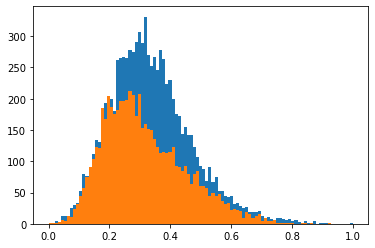

In [49]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.3365616 0.3165016
0.13352174 0.13468893


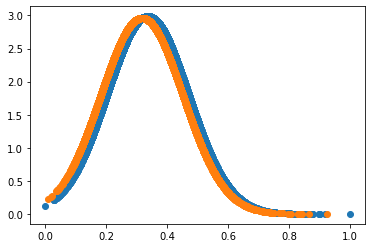

In [50]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

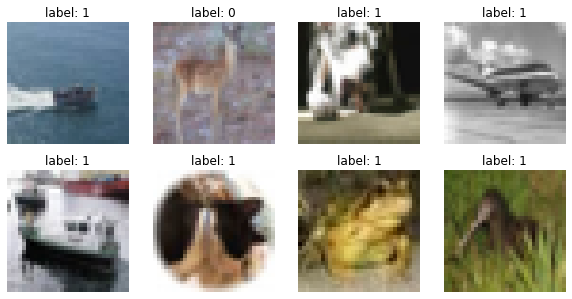

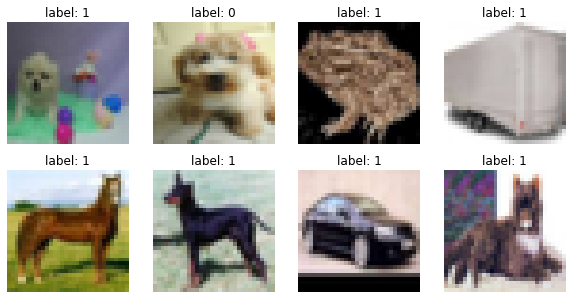

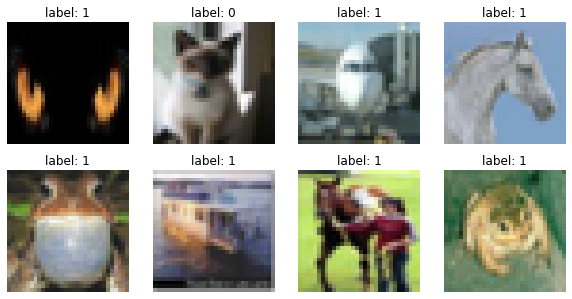

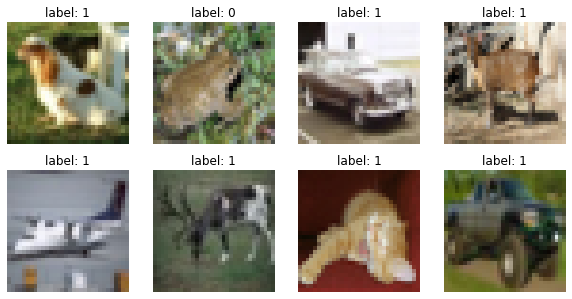

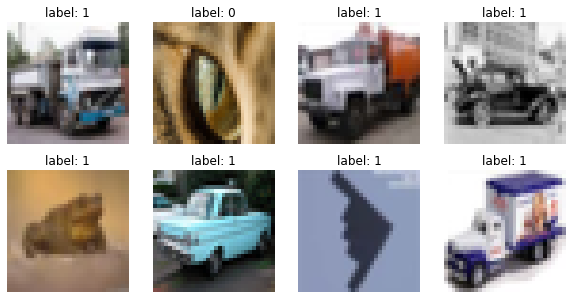

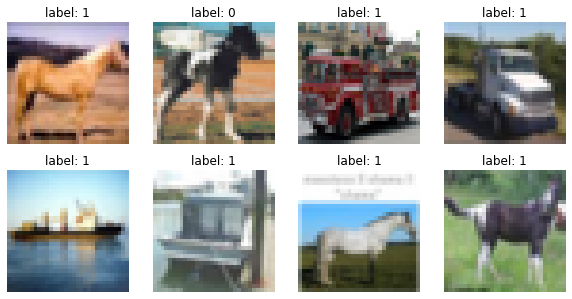

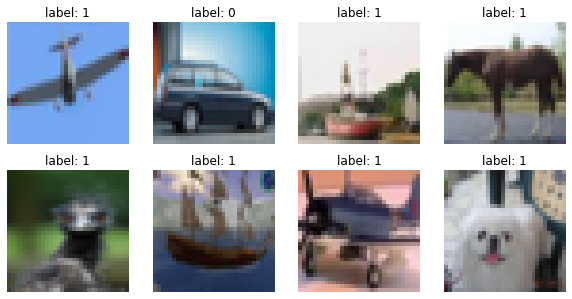

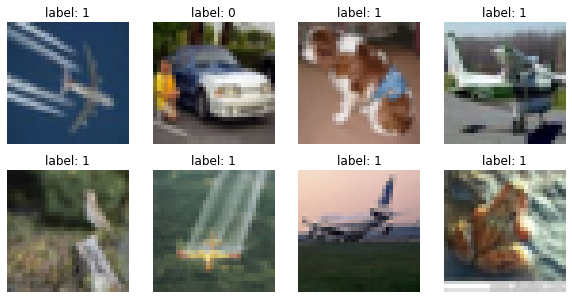

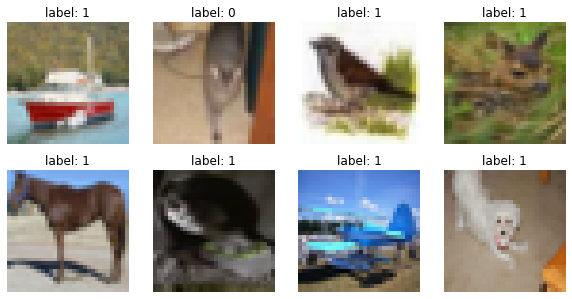

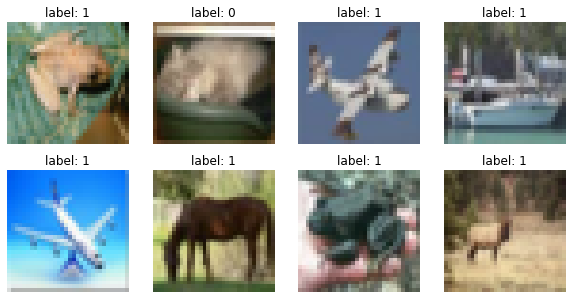

In [60]:
_test = test_dataset.take(10)
_test_score, _test_labels = _evaluate(_test)

for imgs, labels in _test:
    plt.figure(figsize=(10, 5))
    
    for i in range(len(imgs)):
        plt.subplot(2, 4, i + 1)
        plt.imshow((imgs[i] + 1) / 2)
        plt.title(f'label: {_test_labels[i]}')
        plt.axis('off')
    plt.show()

### Report
- 예측시에 개구리를 1로 분류하거나 다른 것을 0으로 분류하는 일이 많다..
- 문제점을 찾아보고 싶은데, 아마 epoch이 너무 작아서 그런 것 같다